In [3]:
import json
api_token = {"username":"iobananaoi","key":"0cbdda23beeb18cbb57e9e88bf26bfd1"}


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b77e60c1d77c14a5a304d0b7dc58909e625f5b8e06dbedcf2804a6e9dece9df3
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=7acf0c3de96d764acfe22e63468db83aa54aabacabb1e4835b7c486a55968d60
  Stored in directory: /root/.cache/pip/w

In [6]:
import os
import gc
import kaggle 
import torch 
import cv2
import copy
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from skimage import io
from datetime import date
from torch import nn
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader
from os import listdir
from os.path import isfile, join
from torchvision.transforms import ToTensor, Compose, ToPILImage, CenterCrop, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.optim import lr_scheduler
from PIL import Image
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
from sklearn.metrics import f1_score   

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
!kaggle datasets download -d faizalkarim/flood-area-segmentation

 99% 106M/107M [00:03<00:00, 43.1MB/s]
100% 107M/107M [00:03<00:00, 34.7MB/s]


In [10]:
f = ZipFile("/content/flood-area-segmentation.zip")
f.extractall("/content/data")

In [11]:
batch_size = 16
epochs = 15
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data processing

In [12]:
class DS(Dataset):
    def __init__(self, transform, label_transform, train=True):
        self.transform = transform
        self.label_transform = label_transform
        self.meta = pd.read_csv("/content/data/metadata.csv")
        self.meta.drop(index=[0,2, 151], inplace=True)

        self.meta = self.meta[:200] if train else self.meta[200:] # Separate the data for train/test stages

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):

        def pil_loader(path):
            with open(path, 'rb') as f:
                with Image.open(f) as img:
                    return img.convert("RGB")

        img = pil_loader("/content/data/Image/"+self.meta.iloc[idx]["Image"])
        label = Image.open("/content/data/Mask/"+self.meta.iloc[idx]["Mask"])
        
        if self.transform:
            img = self.transform(img)
        if self.label_transform:
            label = self.label_transform(label)
        
        return img, label

In [23]:
train_ds = DS(transform=Compose([CenterCrop(188), ToTensor()]), label_transform=Compose([CenterCrop(188), ToTensor()]))
test_ds = DS(transform=Compose([CenterCrop(188), ToTensor()]), label_transform=Compose([CenterCrop(188), ToTensor()]), train=False)

In [24]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size)

In [25]:
batch_num_tr = len(train_ds) // batch_size
batch_num_test = len(test_ds) // batch_size

# Training

In [16]:
def train_model(model, dataloaders: list, loss_fn, optim, scheduler, metrics: dict, batch_stoppers, epochs=epochs):
    model = model.to(device)
    batch_stoppers = {"Train": batch_stoppers[0], "Test": batch_stoppers[1]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    metric_name = list(metrics.keys())[0]
    metric = list(metrics.values())[0]
    since = time.time()
    dataloaders = {"Train": dataloaders[0], "Test": dataloaders[1]}

    model_results = {"Train": {"Loss": [], metric_name: []}, "Test": {"Loss": [], metric_name: []}} # Create dict to represent model results at the end 

    for phase in ["Train", "Test"]:
        if phase == 'Train':
            model.train()  
        else:
            model.eval()
        print(f"******* Phase {phase} *******")

        for epoch in range(epochs):
            print(f"======= Epoch {epoch+1} =======")
            epoch_loss = 0.0
            metric_val = []

            for batch, (X, y) in enumerate(dataloaders[phase]):
                X, y = X.to(device), y.to(device)
                if batch < batch_stoppers[phase]:
                    optim.zero_grad()

                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(X)
                        loss = loss_fn(outputs, y)

                        y_pred = outputs.data.cpu().numpy().ravel()
                        y = y.data.cpu().numpy().ravel()
                        metric_val.append(metric(y > 0, y_pred > 0.1)) # Add metric results to final model results

                        if phase == "Train":
                            loss.backward()
                            optim.step()

                    epoch_loss += loss.item()
            epoch_loss /= batch_stoppers[phase]
            model_results[phase]["Loss"].append(epoch_loss)
            model_results[phase][metric_name].append(np.mean(metric_val))
            print('{} Loss: {:.4f}'.format(phase, loss))

            if phase == 'Train' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())
  

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print(f"Model state saved with the best loss: {best_loss:.4f}")

    model.load_state_dict(best_model_wts) # Load best model weights

    return model, model_results     

In [17]:
def compare_imgs(model, img, mask):
    """ 
    Show three images: Original img, its mask and model prediction. 
    Accepts:
    - model;
    - img in Tensor format;
    - mask in Tensor format;
    """
    model.eval()
    pred = model(img.to(device).unsqueeze(0))
    img, pred = to_pil_image(img.squeeze()), to_pil_image(pred.squeeze())

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(img)
    ax[0].set_title("Original image")
    ax[1].imshow(mask.squeeze())
    ax[1].set_title("Mask")
    ax[2].imshow(pred)
    ax[2].set_title("Model's prediction")
    plt.show()

In [18]:
def show_results(model_results):
    train = model_results["Train"]
    test = model_results["Test"]
    metric = list(model_results["Train"].keys())[1]
    epoch_range = range(epochs)

    plt.figure(figsize=(10, 6))
    for phase in ["Train", "Test"]:
        data = train if phase == "Train" else test
        plt.plot(epoch_range, data["Loss"], label=f"{phase}_loss")
        plt.plot(epoch_range, data[metric], label=f"{phase}_{metric}")
    
    plt.legend()
    plt.show()

## U_net

In [19]:
u_net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True, trust_repo=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

In [26]:
model = u_net
dataloaders = [train_dl, test_dl]
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
metrics = {"f1-score": f1_score}
batch_stoppers = [batch_num_tr, batch_num_test]

In [ ]:
model, unet_results = train_model(model, dataloaders, loss_fn, optim, scheduler, metrics, batch_stoppers, epochs)

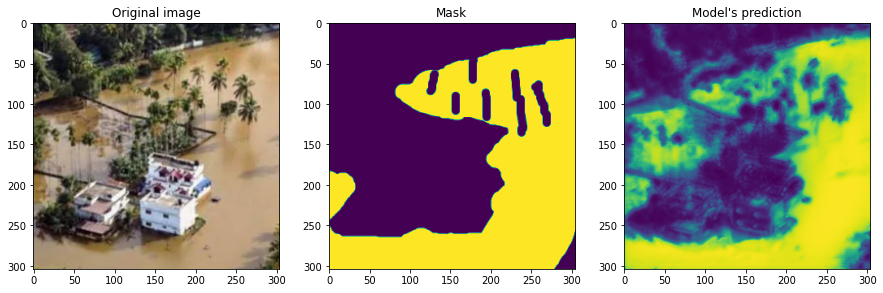

In [ ]:
img, mask = test_ds[random.randint(0, len(test_ds)-1)]
compare_imgs(model, img, mask)

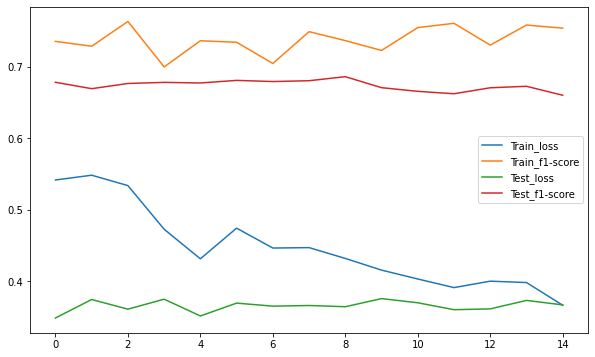

In [ ]:
show_results(unet_results)